## Training target model


### Introduction

1. Pull the latest version of repository - to see, which models were already chosen by others.
2. Install new `requirements.txt`. It should work with python 3.12 and upgraded pip. It contains cuda tensrflow version. If you have problems with installation, try with `requirements-no-gpu.txt`.
3. Check, if tensorflow sees your graphics card.


In [ ]:
# Source - https://stackoverflow.com/a
# Posted by Wilmar van Ommeren, modified by community. See post 'Timeline' for change history
# Retrieved 2026-01-18, License - CC BY-SA 4.0

import tensorflow as tf

tf.config.list_physical_devices("GPU")

it should return something like:

```
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
```

4. Running model involves preparing GPU, downloading data and running appropriate training. Everything is described below.
5. And don't forget to push your name next to chosen model to repository!


#### Use the whole VRAM

Set VRAM size accoring to your GPU!!


In [2]:
from trainer.clipping_model import tf

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
        tf.config.set_logical_device_configuration(
            gpus[0],
            [
                tf.config.LogicalDeviceConfiguration(memory_limit=4000)
            ],  # Limit to 4000 MB of VRAM - TODO: adjust based on your GPU
        )
    except RuntimeError as e:
        print(e)

List models implementations

In [3]:
from trainer.clipping_model import ClipModels  # Import ClipModels Enum

print("Possible models:")
for model in ClipModels:
    print(f"- {model.name}: {model.value}")

Possible models:
- BASE: base_clipping_model
- UNET: unet
- ALEX_INSPIRED: alex_inspired
- SHALLOWED_UNET: shallowed_unet


### Loading data and training model


Model training subsections are divided by grid density. Choose one model training subsection and then please clear cell outputs, **ADD your name in chosen model section header** and push this change on the repository. This should help us avoid conflicts, that 2 people will choose the same model.

So the header sholud like this:

```markdown
##### **GRZEGORZ** 1. Model - shallowed unet 256x256, grid density 1 m
```

#### trainer.random_fit_from_files() arguments

At the moment `epoch_steps` and `epochs` are set to 1. Run it and check, how long does it take to execute it. Then adjust these values to the amout of time you have. `epoch_steps` over 200 probably doesn't make sense, so later on increase just `epochs`.

If it lasts over 15 minutes, it means that probably there is some problem with graphics card. Nevertheless, it should run properly. Model is dumped to a different the file after each training and starts from the last checkpoint everytime, so don't hesitate to run it multiple times, if you want/have time to do it.


In [3]:
import os

data_dir = os.path.join("grids", "with-is-residential")
val_data_dir = os.path.join("grids", "with-is-residential")

#### Grid density 1m


##### Downloading cities


If you have limited disk space, you can adjust `random_cities_count` variable, to download less city grids. It will save time and disk space, but will probably affect model training.
If you do this, please write somewhere down, which cities where used to train model - it will help when writing report.

> **Note:** It lasts for a while - for Częstochowa it is up to 20 minutes


In [ ]:
import random
from scraper.data_loader import DataLoader
import os
from pathlib import Path

random_cities_count = 11

folder_path = Path(data_dir)
folder_path.mkdir(parents=True, exist_ok=True)


# Prefered cities to download
cities = [
    ("Gdańsk, Polska", 466630),
    ("Bydgoszcz, Polska", 358928),
    ("Lublin, Polska", 339433),
    ("Gdynia, Polska", 246635),
    ("Radom, Polska", 214000),
    ("Toruń, Polska", 202074),
    ("Świętochłowice, Polska", 55_000),
    ("Koszalin, Polska", 108_000),
    ("Mielec, Polska", 59_000),
    ("Chorzów, Polska", 110_000),
    ("Rybnik, Polska", 140_000),
]

# List of Polish cities with population between 50,000 and 500,000
# cities = [
#     # ("Warsaw, Polska", 1790658),
#     # ("Kraków, Polska", 780981),
#     # ("Łódź, Polska", 687702),
#     # ("Wrocław, Polska", 640648),
#     # ("Poznań, Polska", 538633),
#     # ("Gdańsk, Polska", 466630),
#     ("Szczecin, Polska", 402465),
#     # ("Bydgoszcz, Polska", 358928),
#     ("Lublin, Polska", 339433),
#     ("Białystok, Polska", 297459),
#     ("Katowice, Polska", 294510),
#     # ("Gdynia, Polska", 246635),
#     ("Częstochowa, Polska", 224000),
#     ("Radom, Polska", 214000),
#     ("Toruń, Polska", 202074),
#     ("Kielce, Polska", 200000),
#     ("Rzeszów, Polska", 196000),
#     ("Opole, Polska", 128000),
#     ("Gliwice, Polska", 180000),
#     ("Zabrze, Polska", 170000),
#     ("Elbląg, Polska", 120000),
#     ("Płock, Polska", 120000),
#     ("Nowy Sącz, Polska", 85_000),
#     ("Słupsk, Polska", 91_000),
#     # ("Świętochłowice, Polska", 55_000),
#     ("Jelenia Góra, Polska", 79_000),
#     ("Stalowa Wola, Polska", 75_000),
#     # ("Koszalin, Polska", 108_000),
#     ("Mielec, Polska", 59_000),
#     ("Legnica, Polska", 100_000),
#     ("Tychy, Polska", 130_000),
#     ("Chorzów, Polska", 110_000),
#     # ("Rybnik, Polska", 140_000)
# ]

# Randomly select cities
random_cities = random.sample(cities, random_cities_count)

loader = DataLoader(1, 500, 500, data_dir=data_dir)
managers = []
files = []

for city, population in random_cities:
    file_name = city.replace(", ", "-") + ".city_grid"
    print(f"Loading grid of city: {city} to {os.path.join(data_dir, file_name)}")
    manager = loader.load_city_grid(city, file_name)
    files.append(file_name)
    managers.append(manager)
    loader.add_elevation_to_grid(manager)
    loader.add_residential_to_grid(manager, city_name=city)

#### Download only one city grid

In [ ]:
from scraper.data_loader import DataLoader
import os
from pathlib import Path

folder_path = Path(data_dir)
folder_path.mkdir(parents=True, exist_ok=True)

city = "Nowy Targ, Polska"
loader = DataLoader(1, 500, 500, data_dir=data_dir)
manager = None
file_name = city.replace(", ", "-") + ".city_grid"
print(f"Loading grid of city: {city} to {os.path.join(data_dir, file_name)}")
manager = loader.load_city_grid(city, file_name)
loader.add_elevation_to_grid(manager)
loader.add_residential_to_grid(manager, city_name=city)

#### Example of adding one third dimension value if something fails above

In [ ]:
from grid_manager import GridManager

city = "Rybnik, Polska"
file_name = city.replace(", ", "-") + ".city_grid"
manager = GridManager(file_name=file_name, data_dir=data_dir)
# loader.add_elevation_to_grid(manager)
loader.add_residential_to_grid(manager, city_name=city)

#### If you want zeros instead:

In [ ]:
import math
import numpy as np
from grid_manager import GridManager


def add_zero_dimension_third_channel(grid_manager: GridManager, dimension_index: int):
    meta = grid_manager.get_metadata()

    segments_rows = math.ceil(meta.rows_number / meta.segment_h)
    segments_cols = math.ceil(meta.columns_number / meta.segment_w)

    for row_idx in range(segments_rows):
        for col_idx in range(segments_cols):
            segment = grid_manager.read_segment(row_idx, col_idx)

            h, w, _ = segment.shape

            for y in range(h):
                for x in range(w):
                    segment[y, x, dimension_index] = 0

            grid_manager.write_segment(segment, row_idx, col_idx)

            print(
                f"Segment [{row_idx}, {col_idx}] saved. Max value in dimension {dimension_index}: {np.max(segment[:, :, dimension_index]):.2f}"
            )

In [ ]:
from grid_manager import GridManager
from pathlib import Path
import random

random_cities_count = 11

folder = Path(data_dir)
folder.mkdir(parents=True, exist_ok=True)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
print(f"files: {files}")

cities = [
    ("Gdańsk, Polska", 466630),
    ("Bydgoszcz, Polska", 358928),
    ("Lublin, Polska", 339433),
    ("Gdynia, Polska", 246635),
    ("Radom, Polska", 214000),
    ("Toruń, Polska", 202074),
    ("Świętochłowice, Polska", 55_000),
    ("Koszalin, Polska", 108_000),
    ("Mielec, Polska", 59_000),
    ("Chorzów, Polska", 110_000),
    ("Rybnik, Polska", 140_000),
]

random_cities = random.sample(cities, random_cities_count)
for city, population in random_cities:
    file_name = city.replace(", ", "-") + ".city_grid"
    print(f"Loading grid of city: {city} to {os.path.join(data_dir, file_name)}")
    grid_manager = GridManager(file_name, data_dir=data_dir)
    add_zero_dimension_third_channel(grid_manager, dimension_index=1)
    add_zero_dimension_third_channel(grid_manager, dimension_index=2)

#### Model input data generating


##### Get an input clipping for the model `WARNING: You may need to run the cell below several times in order not to get a void fragment`

##### Only is_street

Text(0.5, 1.0, 'predicted road (input for the model)')

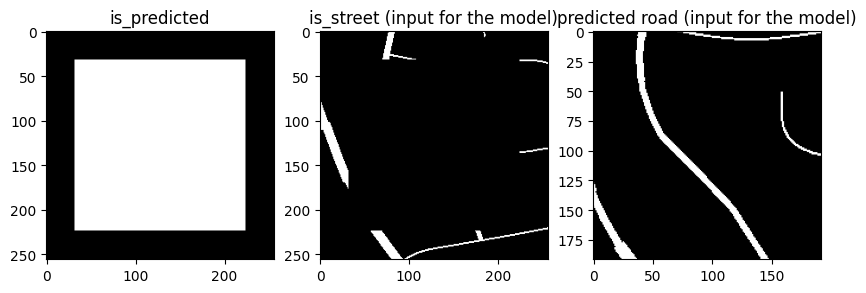

In [ ]:
from trainer.data_generator import clipping_sample_generator
from pathlib import Path
from grid_manager import GridManager

data_dir = "grids/with-is-residential"

# Example usage of the data generator
# Assuming you have a list of GridManager instances in `files` and a model instance `model`
files = [GridManager(f.name, data_dir=data_dir) for f in Path(data_dir).iterdir() if f.is_file()]
data_gen = clipping_sample_generator(
    grid_managers=files,
    cut_sizes=[(256, 256)],  # size of the clipping (input to the model)
    clipping_size=256,  # size of the clipping (input to the model)
    input_surplus=64,  # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    input_third_dimension=2,  # of channels in the input grid (e.g., 2 for is_predicted, is_street)
    output_third_dimension=1,  # of channels in the output grid (e.g., 1 for predicted road)
)
# To get a batch of data from the generator, you can use:
X_batch, y_batch = next(data_gen)

from matplotlib import pyplot as plt

# Visualize the first sample in the batch
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(X_batch[:, :, 0], cmap="gray")  # is_predicted channel
axs[0].set_title("is_predicted")
axs[1].imshow(X_batch[:, :, 1], cmap="gray")  # is_street channel
axs[1].set_title("is_street (input for the model)")
axs[2].imshow(y_batch["is_street"], cmap="gray")  # predicted road
axs[2].set_title("predicted road (input for the model)")

##### All third dimensions

Text(0.5, 1.0, 'predicted is_residential (input for the model)')

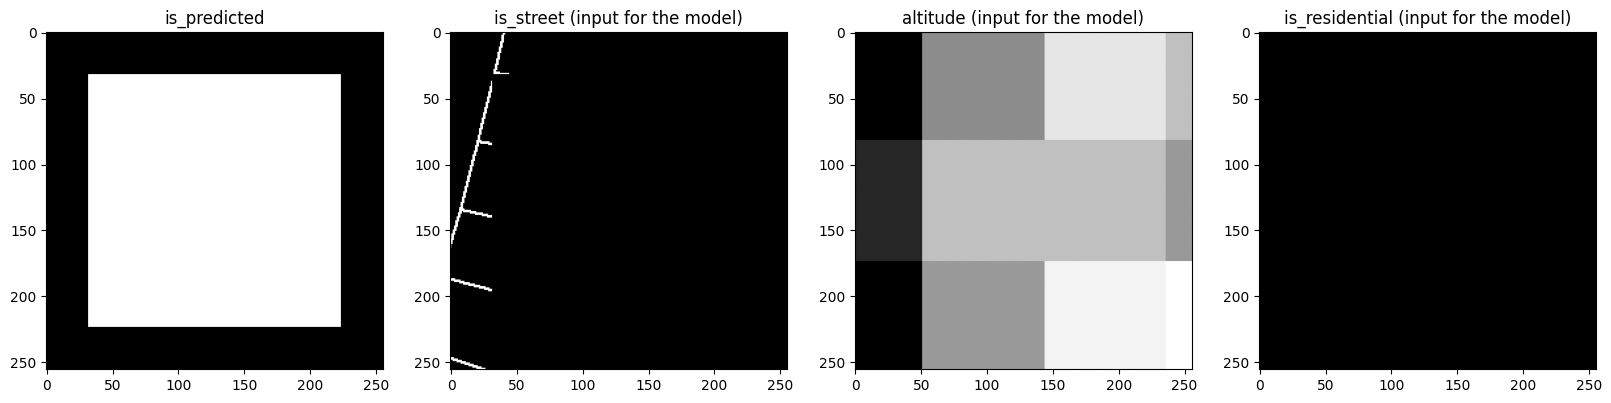

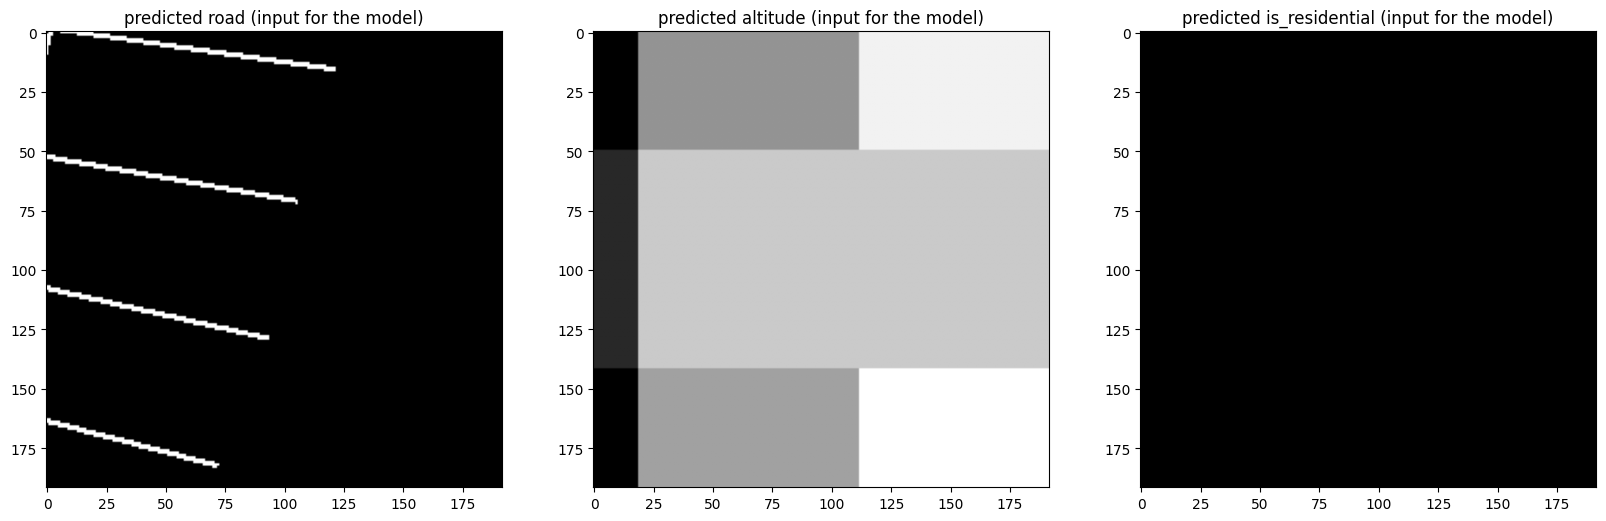

In [ ]:
from trainer.data_generator import clipping_sample_generator
from pathlib import Path
from grid_manager import GridManager

data_dir = "grids/with-is-residential"

# Example usage of the data generator
# Assuming you have a list of GridManager instances in `files` and a model instance `model`
files = [GridManager(f.name, data_dir=data_dir) for f in Path(data_dir).iterdir() if f.is_file()]
data_gen = clipping_sample_generator(
    grid_managers=files,
    cut_sizes=[(256, 256)],  # size of the clipping (input to the model)
    clipping_size=256,  # size of the clipping (input to the model)
    input_surplus=64,  # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    input_third_dimension=4,  # of channels in the input grid (e.g., 2 for is_predicted, is_street)
    output_third_dimension=3,  # of channels in the output grid (e.g., 1 for predicted road)
)
# To get a batch of data from the generator, you can use:
X_batch, y_batch = next(data_gen)

from matplotlib import pyplot as plt

# Visualize the first sample in the batch
fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(X_batch[:, :, 0], cmap="gray")  # is_predicted channel
axs[0].set_title("is_predicted")
axs[1].imshow(X_batch[:, :, 1], cmap="gray")  # is_street channel
axs[1].set_title("is_street (input for the model)")
axs[2].imshow(X_batch[:, :, 2], cmap="gray")  # altitude channel
axs[2].set_title("altitude (input for the model)")
axs[3].imshow(X_batch[:, :, 3], cmap="gray")  # is_residential channel
axs[3].set_title("is_residential (input for the model)")

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(y_batch["is_street"], cmap="gray")  # predicted road
axs[0].set_title("predicted road (input for the model)")
axs[1].imshow(y_batch["altitude"], cmap="gray")  # predicted altitude
axs[1].set_title("predicted altitude (input for the model)")
axs[2].imshow(y_batch["is_residential"], cmap="gray")  # predicted is_residential
axs[2].set_title("predicted is_residential (input for the model)")

#### Models

##### **GRZEGORZ** 1.1. Model - shallowed unet 256x256, grid density 1 m


In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel
from trainer.trainer import Trainer
from pathlib import Path
from grid_manager import GridManager

model = ClippingModel(  # Define the model
    ClipModels.SHALLOWED_UNET,  # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=256,  # size of the clipping (input to the model)
    clipping_surplus=64,  # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "shallowed_unet_256_1m"),  # where to save the model
    input_third_dimension=4,
    output_third_dimension=3,
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
val_folder = Path(val_data_dir)
val_files = [GridManager(f.name, data_dir=val_data_dir) for f in val_folder.iterdir() if f.is_file()]
print(f"files: {[manager._file_name for manager in files]}")
print(f"val_files: {[manager._file_name for manager in val_files]}")

trainer = Trainer(  # Initialize the trainer with the model and data files
    model=model, files=files, val_files=val_files  # the model defined above
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=3,  # number of epochs to train
    steps_per_epoch=50,  # number of steps per epoch
    batch_size=8,  # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

##### **JAKUB** 1.2. Model - shallowed unet 256x256, grid density 1 m - **no altitude**

In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel
from trainer.trainer import Trainer
from pathlib import Path
from grid_manager import GridManager

model = ClippingModel(  # Define the model
    model_type=ClipModels.SHALLOWED_UNET,  # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=256,  # size of the clipping (input to the model)
    clipping_surplus=64,  # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "shallowed_unet_256_1m_is_street_only"),  # where to save the model
    input_third_dimension=2,
    output_third_dimension=1,
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
val_folder = Path(val_data_dir)
val_files = [GridManager(f.name, data_dir=val_data_dir) for f in val_folder.iterdir() if f.is_file()]
print(f"files: {[manager._file_name for manager in files]}")
print(f"val_files: {[manager._file_name for manager in val_files]}")

trainer = Trainer(  # Initialize the trainer with the model and data files
    model=model, files=files, val_files=val_files  # the model defined above
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=150,  # number of epochs to train
    steps_per_epoch=150,  # number of steps per epoch
    batch_size=16,  # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

##### 2. Model unet 256x256, grid density 1 m


In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel
from trainer.trainer import Trainer
from pathlib import Path

model = ClippingModel(  # Define the model
    ClipModels.UNET,  # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=256,  # size of the clipping (input to the model)
    clipping_surplus=64,  # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "unet_256_1m"),  # where to save the model
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
val_folder = Path(val_data_dir)
val_files = [GridManager(f.name, data_dir=val_data_dir) for f in val_folder.iterdir() if f.is_file()]
print(f"files: {[manager._file_name for manager in files]}")
print(f"val_files: {[manager._file_name for manager in val_files]}")

trainer = Trainer(  # Initialize the trainer with the model and data files
    model=model, files=files, val_files=val_files  # the model defined above
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=1,  # number of epochs to train
    steps_per_epoch=1,  # number of steps per epoch
    batch_size=8,  # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

##### **Jakub** 3. Model unet 512x512, grid density 1 m


In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel
from trainer.trainer import Trainer
from pathlib import Path

model = ClippingModel(  # Define the model
    ClipModels.UNET,  # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=512,  # size of the clipping (input to the model)
    clipping_surplus=128,  # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "unet_512_1m"),  # where to save the model
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
val_folder = Path(val_data_dir)
val_files = [GridManager(f.name, data_dir=val_data_dir) for f in val_folder.iterdir() if f.is_file()]
print(f"files: {[manager._file_name for manager in files]}")
print(f"val_files: {[manager._file_name for manager in val_files]}")

trainer = Trainer(  # Initialize the trainer with the model and data files
    model=model, files=files, val_files=val_files  # the model defined above
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=1,  # number of epochs to train
    steps_per_epoch=1,  # number of steps per epoch
    batch_size=8,  # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

#### Grid density 2 m


If you have limited disk space, you can adjust `random_cities_count` variable, to download less city grids. It will save time and disk space, but will probably affect model training.
If you do this, please write somewhere down, which cities where used to train model - it will help when writing report.

> **Note:** It lasts for a while - for Częstochowa it is up to 20 minutes


In [ ]:
import random
from scraper.data_loader import DataLoader
import os
from pathlib import Path

random_cities_count = 11

folder_path = Path(data_dir)
folder_path.mkdir(parents=True, exist_ok=True)


# Prefered cities to download
cities = [
    ("Gdańsk, Polska", 466630),
    ("Bydgoszcz, Polska", 358928),
    ("Lublin, Polska", 339433),
    ("Gdynia, Polska", 246635),
    ("Radom, Polska", 214000),
    ("Toruń, Polska", 202074),
    ("Świętochłowice, Polska", 55_000),
    ("Koszalin, Polska", 108_000),
    ("Mielec, Polska", 59_000),
    ("Chorzów, Polska", 110_000),
    ("Rybnik, Polska", 140_000),
]

# List of Polish cities with population between 50,000 and 500,000
# cities = [
#     # ("Warsaw, Polska", 1790658),
#     # ("Kraków, Polska", 780981),
#     # ("Łódź, Polska", 687702),
#     # ("Wrocław, Polska", 640648),
#     # ("Poznań, Polska", 538633),
#     # ("Gdańsk, Polska", 466630),
#     ("Szczecin, Polska", 402465),
#     # ("Bydgoszcz, Polska", 358928),
#     ("Lublin, Polska", 339433),
#     ("Białystok, Polska", 297459),
#     ("Katowice, Polska", 294510),
#     # ("Gdynia, Polska", 246635),
#     ("Częstochowa, Polska", 224000),
#     ("Radom, Polska", 214000),
#     ("Toruń, Polska", 202074),
#     ("Kielce, Polska", 200000),
#     ("Rzeszów, Polska", 196000),
#     ("Opole, Polska", 128000),
#     ("Gliwice, Polska", 180000),
#     ("Zabrze, Polska", 170000),
#     ("Elbląg, Polska", 120000),
#     ("Płock, Polska", 120000),
#     ("Nowy Sącz, Polska", 85_000),
#     ("Słupsk, Polska", 91_000),
#     # ("Świętochłowice, Polska", 55_000),
#     ("Jelenia Góra, Polska", 79_000),
#     ("Stalowa Wola, Polska", 75_000),
#     # ("Koszalin, Polska", 108_000),
#     ("Mielec, Polska", 59_000),
#     ("Legnica, Polska", 100_000),
#     ("Tychy, Polska", 130_000),
#     ("Chorzów, Polska", 110_000),
#     # ("Rybnik, Polska", 140_000)
# ]

# Randomly select cities
random_cities = random.sample(cities, random_cities_count)

loader = DataLoader(2, 5000, 5000, data_dir=data_dir)
managers = []
files = []

for city, population in random_cities:
    file_name = city.replace(", ", "-") + ".city_grid"
    print(f"Loading grid of city: {city} to {os.path.join(data_dir, file_name)}")
    manager = loader.load_city_grid(city, file_name)
    files.append(file_name)
    managers.append(manager)
    loader.add_elevation_to_grid(manager)
    loader.add_residential_to_grid(manager)

##### 4. Model unet 256x256, grid density 2 m


In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel
from trainer.trainer import Trainer
from pathlib import Path

model = ClippingModel(  # Define the model
    ClipModels.UNET,  # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=256,  # size of the clipping (input to the model)
    clipping_surplus=64,  # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "unet_256_2m"),  # where to save the model
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
val_folder = Path(val_data_dir)
val_files = [GridManager(f.name, data_dir=val_data_dir) for f in val_folder.iterdir() if f.is_file()]
print(f"files: {[manager._file_name for manager in files]}")
print(f"val_files: {[manager._file_name for manager in val_files]}")

trainer = Trainer(  # Initialize the trainer with the model and data files
    model=model, files=files, val_files=val_files  # the model defined above
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=1,  # number of epochs to train
    steps_per_epoch=1,  # number of steps per epoch
    batch_size=8,  # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

##### 5. Model unet 512x512, grid density 2 m


In [ ]:
import os
from trainer.clipping_model import ClipModels, ClippingModel
from trainer.trainer import Trainer
from pathlib import Path

model = ClippingModel(  # Define the model
    ClipModels.UNET,  # choose a model from ClipModels Enum (run the cell above to see possible models)
    clipping_size=512,  # size of the clipping (input to the model)
    clipping_surplus=128,  # surplus around the clipping (model gives an output smaller than input, so surplus is needed)
    path=os.path.join("models", "unet_512_2m"),  # where to save the model
)

folder = Path(data_dir)
files = [GridManager(f.name, data_dir=data_dir) for f in folder.iterdir() if f.is_file()]
val_folder = Path(val_data_dir)
val_files = [GridManager(f.name, data_dir=val_data_dir) for f in val_folder.iterdir() if f.is_file()]
print(f"files: {[manager._file_name for manager in files]}")
print(f"val_files: {[manager._file_name for manager in val_files]}")

trainer = Trainer(  # Initialize the trainer with the model and data files
    model=model, files=files, val_files=val_files  # the model defined above
)

In [ ]:
trainer.random_fit_from_files(  # Train the model with random data from files
    epochs=1,  # number of epochs to train
    steps_per_epoch=1,  # number of steps per epoch
    batch_size=8,  # size of each training batch
)
# after measuring step duration, adjust steps_per_epoch (max. around 200) and epochs to the amout of time you have

## Evaluation

Evaluation with visualisation functions

In [4]:
from grid_manager import GridManager
import matplotlib.pyplot as plt
import numpy as np
import time
from trainer.model import PREDICT_GRID_INDICES
from trainer.clipping_model import ClippingModel


# Function to test the prediction on a specific fragment of the city grid
def test_predict_on_fragment(
    grid_manager: GridManager,  # the grid manager of the city grid you want to test on
    model: ClippingModel,  # the model you want to test
    fragment_row: int,  # the row index of the top-left corner of the fragment you want to test on
    fragment_col: int,  # the column index of the top-left corner of the fragment you want to test on
    fragment_height: int,  # the height of the fragment you want to test on
    fragment_width: int,  # the width of the fragment you want to test on
):
    metadata = grid_manager.get_metadata()
    print("city height: ", metadata.rows_number)
    print("city width: ", metadata.columns_number)

    assert (
        metadata.third_dimension_size == 3
    ), "You have an outdated version of GridManager. Consider downloading grid files again to get all data..."

    segment_h, segment_w = metadata.segment_h, metadata.segment_w
    being_predicted = GridManager(
        f"test_{time.time()}.city_grid",
        fragment_height,
        fragment_width,
        0,
        0,
        metadata.grid_density,
        segment_h,
        segment_w,
        data_dir="grids/evaluation",
        third_dimension_size=model.input_third_dimension,
    )
    # read_arbitrary_fragment does not take care of memory size - if there are some problems - just use smaller fragment
    # Add IS_PREDICTED
    tmp = np.ones((fragment_height, fragment_width, model.input_third_dimension))
    tmp[:, :, 1 : model.input_third_dimension] = grid_manager.read_arbitrary_fragment(
        row=fragment_row, col=fragment_col, height=fragment_height, width=fragment_width
    )[:, :, : model.input_third_dimension - 1]

    being_predicted.write_arbitrary_fragment(fragment=tmp, row=0, col=0)  # for instance some segment in the middle

    result = model.predict(being_predicted)
    img = result.read_arbitrary_fragment(
        row=0,
        col=0,
        height=fragment_height - model.get_input_grid_surplus(),
        width=fragment_width - model.get_input_grid_surplus(),
    )[:, :, PREDICT_GRID_INDICES.IS_STREET]

    print(f"DEBUG: img.max(): {img.max()}")

    # Visualize the prediction
    ## INPUT
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(tmp[:, :, 0], cmap="gray")  # is_predicted channel
    axs[0].set_title("is_predicted")
    axs[1].imshow(tmp[:, :, 1], cmap="gray")  # is_street channel
    axs[1].set_title("is_street (input for the model)")
    ## OUTPUT
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[1].imshow(img, cmap="gray")  # predicted road
    axs[1].set_title("predicted road (OUTPUT)")

    ## OUTPUT - fragment
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[1].imshow(
        img[
            fragment_height // 2 : fragment_height // 2 + fragment_height // 4,
            fragment_width // 2 : fragment_width // 2 + fragment_width // 4,
        ],
        cmap="gray",
    )  # predicted road
    axs[1].set_title(
        f"predicted road (OUTPUT) - fragment: [{fragment_height // 2}, {fragment_width // 2}] - size: [{fragment_height // 4}, {fragment_width // 4}]"
    )


def show_fragment_and_test_predict(
    grid_manager: GridManager,  # the grid manager of the city grid you want to test on
    model: ClippingModel,  # the model you want to test
    fragment_row: int,  # the row index of the top-left corner of the fragment you want to test on
    fragment_col: int,  # the column index of the top-left corner of the fragment you want to test on
    fragment_height: int,  # the height of the fragment you want to test on
    fragment_width: int,  # the width of the fragment you want to test on
):
    # Show the fragment of the city grid with dimensions (5000, 5000) starting from (8000, 6000)

    metadata = grid_manager.get_metadata()
    print("city height: ", metadata.rows_number)
    print("city width: ", metadata.columns_number)

    fragment = grid_manager.read_arbitrary_fragment(
        row=fragment_row, col=fragment_col, height=fragment_height, width=fragment_width
    )

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.imshow(fragment[:, :, 0], cmap="gray")

    # Predict on the fragment of the city grid with dimensions (5000, 5000) starting from (8000, 6000)

    test_predict_on_fragment(grid_manager, model, fragment_row, fragment_col, fragment_height, fragment_width)

#### IS_STREET only model

##### A city from train dataset

Starting from file: models/shallowed_unet_256_1m_is_street_only/1770926494_model.keras
city height:  17351
city width:  19900
city height:  17351
city width:  19900
DEBUG: input.third_dimension_size: 2

row: 0..........................
row: 1..........................
row: 2..........................
row: 3..........................
row: 4..........................
row: 5..........................
row: 6..........................
row: 7..........................
row: 8..........................
row: 9..........................
row: 10..........................
row: 11..........................
row: 12..........................
row: 13..........................
row: 14..........................
row: 15..........................
row: 16..........................
row: 17..........................
row: 18..........................
row: 19..........................
row: 20..........................
row: 21..........................
row: 22..........................
row: 23..................

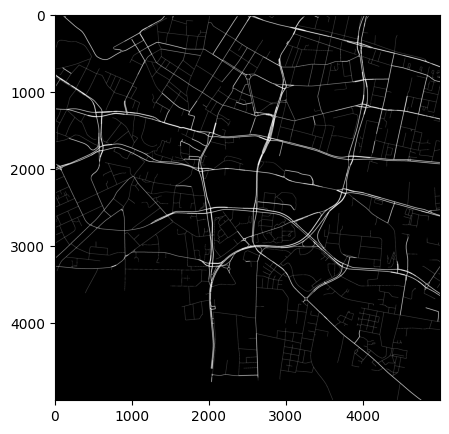

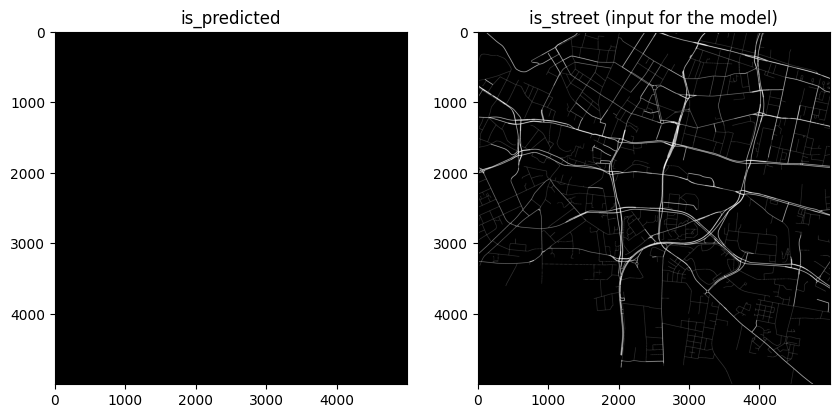

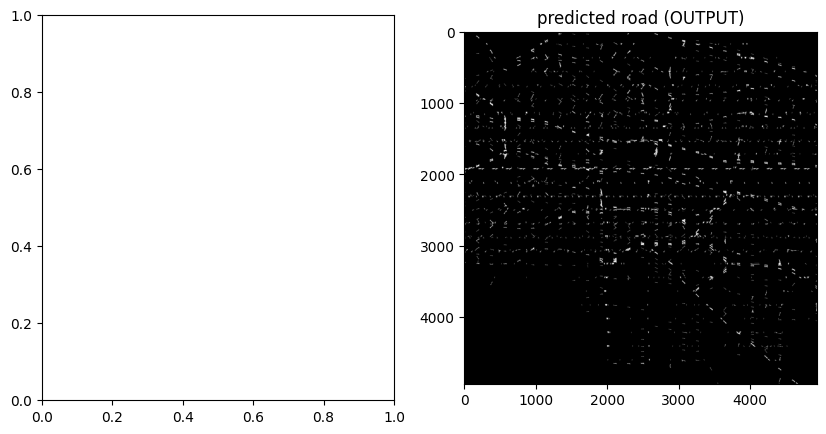

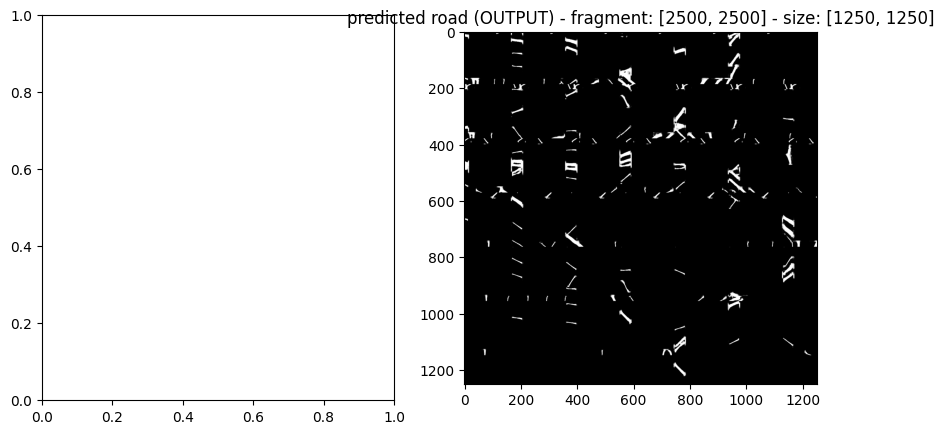

In [5]:
from grid_manager import GridManager
import os
from trainer.clipping_model import ClipModels, ClippingModel

model = ClippingModel(
    ClipModels.SHALLOWED_UNET,
    clipping_size=256,
    clipping_surplus=64,
    path=os.path.join("models", "shallowed_unet_256_1m_is_street_only"),
    input_third_dimension=2,
    output_third_dimension=1,
)

grid_manager = GridManager("Bydgoszcz-Polska.city_grid", data_dir="grids/with-is-residential")
fragment_row, fragment_col = 8000, 6000
fragment_height, fragment_width = 5000, 5000

show_fragment_and_test_predict(grid_manager, model, fragment_row, fragment_col, fragment_height, fragment_width)

##### Check for a completely New city:

Starting from file: models/shallowed_unet_256_1m_is_street_only/1770926494_model.keras
city height:  8314
city width:  6433
city height:  8314
city width:  6433
DEBUG: input.third_dimension_size: 2

row: 0...........
row: 1...........
row: 2...........
row: 3...........
row: 4...........
row: 5...........
row: 6...........
row: 7...........
row: 8...........
row: 9...........
row: 10...........DEBUG: img.max(): 1.0


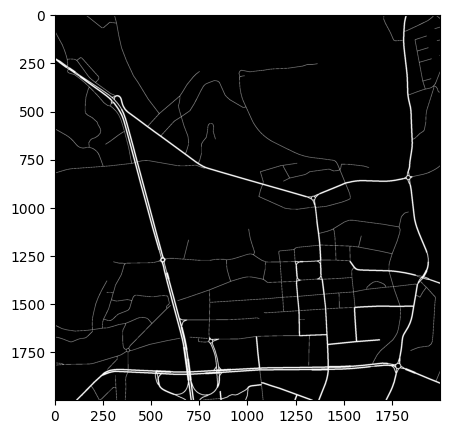

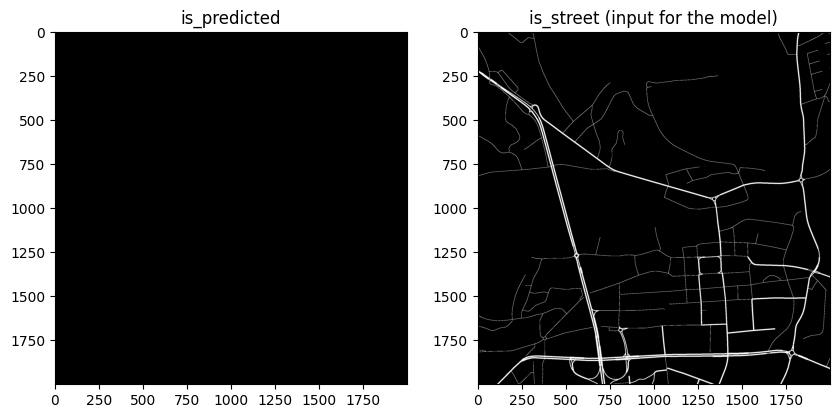

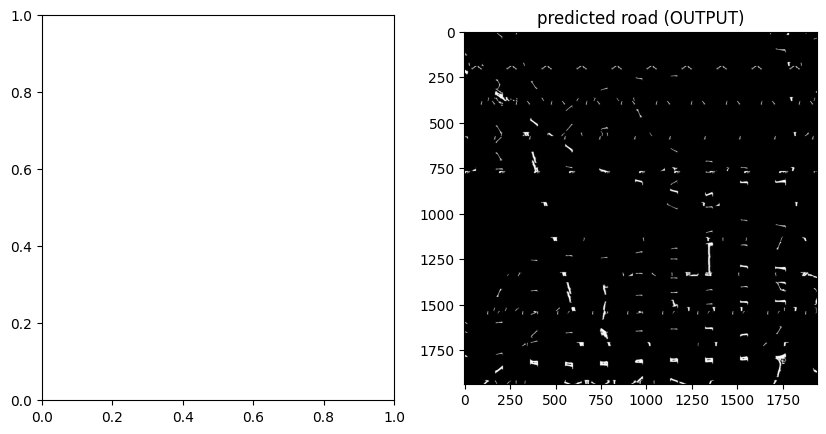

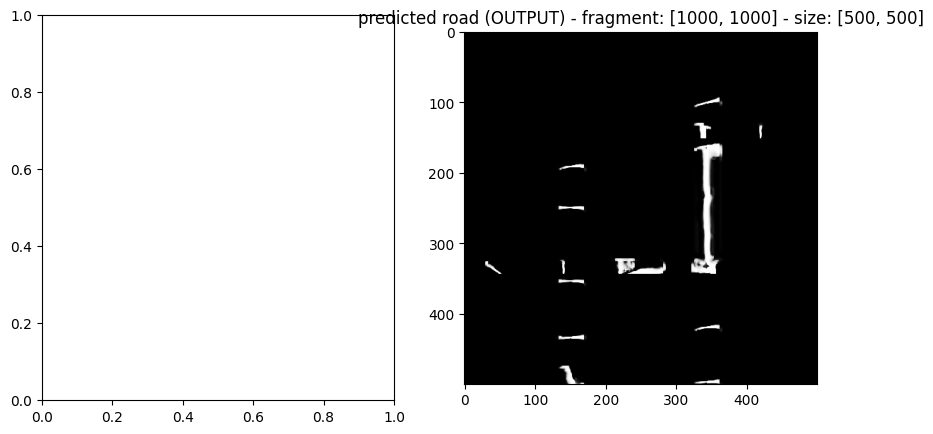

In [6]:
from grid_manager import GridManager
import matplotlib.pyplot as plt
from trainer.clipping_model import ClipModels, ClippingModel

model = ClippingModel(
    ClipModels.SHALLOWED_UNET,
    clipping_size=256,
    clipping_surplus=64,
    path=os.path.join("models", "shallowed_unet_256_1m_is_street_only"),
    input_third_dimension=2,
    output_third_dimension=1,
)

grid_manager = GridManager("Nowy Targ-Polska.city_grid", data_dir="grids/with-is-residential")
fragment_row, fragment_col = 3000, 2000
fragment_height, fragment_width = 2000, 2000

show_fragment_and_test_predict(grid_manager, model, fragment_row, fragment_col, fragment_height, fragment_width)

## Examples of modules usages


### Download mesh and get grid from OSM


In [12]:
from scraper.data_loader import DataLoader
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
# IMPORTANT!! - dataloader checks, if the file already exists
from scraper.data_loader import DataLoader

cityname = "Kraków"

loader = DataLoader(1)

grid_manager = loader.load_city_grid(cityname, cityname + ".dat")
# loader.add_elevation_to_grid(grid_manager)
loader.add_residential_to_grid(grid_manager)

#### Display downloaded grid (dilated to be better visible)


In [ ]:
from grid_manager import GridManager
import matplotlib.pyplot as plt
import cv2
import numpy as np

grid_manager = GridManager("Tychy.dat", data_dir="grids")
img = grid_manager.read_segment(2, 0)[:5000, :5000, 0]

struct_el = np.ones((3, 3))
dilated = cv2.dilate(img, struct_el, iterations=3)
plt.gray()
plt.imshow(dilated)

#### Adding is residential tests


In [ ]:
# IMPORTANT!! - dataloader checks, if the file already exists
from scraper.data_loader import DataLoader

cityname = "Tychy"

loader = DataLoader(1)

grid_manager = loader.load_city_grid(cityname, cityname + ".dat")
# loader.add_elevation_to_grid(grid_manager)
loader.add_residential_to_grid(grid_manager)

In [ ]:
from grid_manager import GridManager
from scraper.rasterizer import Rasterizer
import matplotlib.pyplot as plt
import math

grid_manager = GridManager("Toruń.dat")
meta = grid_manager.get_metadata()
segments_rows = math.ceil(meta.rows_number / meta.segment_h)
segments_cols = math.ceil(meta.columns_number / meta.segment_w)


rasterizer = Rasterizer()
fig, axes = plt.subplots(segments_rows, segments_cols)
fig.set_size_inches((16, 16))
axes = axes.flatten()
axes_index = 0

for row_idx in range(segments_rows):
    for col_idx in range(segments_cols):
        segment = grid_manager.read_segment(row_idx, col_idx)

        axes[axes_index].imshow(segment[:, :, 2], cmap="gray")
        axes[axes_index].set_title(f"Segment_rows: {row_idx}, segment_cols: {col_idx}")
        axes_index += 1

In [ ]:
from grid_manager import GridManager
from scraper.rasterizer import Rasterizer
import matplotlib.pyplot as plt
import math

grid_manager = GridManager("Toruń.dat")
meta = grid_manager.get_metadata()
segments_rows = math.ceil(meta.rows_number / meta.segment_h)
segments_cols = math.ceil(meta.columns_number / meta.segment_w)


rasterizer = Rasterizer()
fig, axes = plt.subplots(segments_rows, segments_cols)
fig.set_size_inches((16, 16))
axes = axes.flatten()
axes_index = 0

for row_idx in range(segments_rows):
    for col_idx in range(segments_cols):
        segment = grid_manager.read_segment(row_idx, col_idx)

        axes[axes_index].imshow(segment[:, :, 0], cmap="gray")
        axes[axes_index].set_title(f"Segment_rows: {row_idx}, segment_cols: {col_idx}")
        axes_index += 1

In [ ]:
from grid_manager import GridManager

grid_manager = GridManager("Tychy.dat")
img = grid_manager.read_segment(1, 1)[:2000, :2000, 0]

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle("Obrazki dróg (zdylatowane, żeby było lepiej widać)")

imgs = [
    [grid_manager.read_segment(0, 0)[3000:, 3000:, 0], grid_manager.read_segment(0, 1)[3000:, :2000, 0]],
    [grid_manager.read_segment(1, 0)[:2000, 3000:, 0], grid_manager.read_segment(1, 1)[:2000, :2000, 0]],
]

dilated_imgs = []

struct_el = np.ones((3, 3))

for imgs_row in imgs:
    target_row = []
    dilated_imgs.append(target_row)
    for img in imgs_row:
        target_row.append(cv2.dilate(img, struct_el, iterations=3))

plt.gray()
axs[0, 0].imshow(dilated_imgs[0][0])
axs[0, 1].imshow(dilated_imgs[0][1])
axs[1, 0].imshow(dilated_imgs[1][0])
axs[1, 1].imshow(dilated_imgs[1][1])

In [ ]:
from scraper.grid_builder import GridBuilder
import math
from scraper.rasterizer import Rasterizer
import matplotlib.pyplot as plt

city = "Tychy, Polska"
builder = GridBuilder()

gdf_edges = builder.get_city_roads(city)

rasterizer = Rasterizer()

grid_2d = rasterizer.get_rasterize_roads(gdf_edges, 1, is_residential=False)
plt.imshow(grid_2d, cmap="gray")
plt.title(f"City: {city}")

In [ ]:
from scraper.grid_builder import GridBuilder
import math
from scraper.rasterizer import Rasterizer
import matplotlib.pyplot as plt
import geopandas as gpd

city = "Kraków"
builder = GridBuilder()
grid_density = 1
segment_h = 5000
segment_w = 5000
data_dir = "grids"

gdf_edges = builder.get_city_roads(city)
min_x, min_y, max_x, max_y = gdf_edges.total_bounds

columns_number = math.ceil((max_x - min_x) / grid_density)
rows_number = math.ceil((max_y - min_y) / grid_density)

segment_rows = math.ceil((rows_number) / segment_h)
segment_cols = math.ceil((columns_number) / segment_h)

# grid_manager = GridManager(file_name, rows_number=int(rows_number), columns_number=int(columns_number),
#                             grid_density=grid_density, segment_h=segment_h, segment_w=segment_w,
#                             data_dir=data_dir, upper_left_longitude=min_x, upper_left_latitude=max_y)
print(f"Height: {int(rows_number)}, Width: {int(columns_number)}, rows: {segment_rows}, cols: {segment_cols}")

rasterizer = Rasterizer()
fig, axes = plt.subplots(segment_rows, segment_cols)
fig.set_size_inches((16, 16))
axes = axes.flatten()
axes_index = 0
# single_row_gdf = gdf_edges.sample(1)

# grid_2d = rasterizer.rasterize_segment_from_indexes(gdf_edges=single_row_gdf, indexes=(0, 0), is_residential=False
#                                                             size_h=segment_h, size_w=segment_w,
#                                                             pixel_size=grid_density)
# print(grid_2d.shape)
# plt.imshow(grid_2d, cmap="gray")

for i in range(segment_rows):
    for j in range(segment_cols):
        grid_2d = rasterizer.rasterize_segment_from_indexes(
            gdf_edges=gdf_edges,
            indexes=(i, j),
            is_residential=False,
            size_h=segment_h,
            size_w=segment_w,
            pixel_size=grid_density,
        )
        axes[axes_index].imshow(grid_2d, cmap="gray")
        axes[axes_index].set_title(f"Segment_rows: {i}, segment_cols: {j}")
        axes_index += 1

### Data management


In [ ]:
from grid_manager import GridManager
import numpy as np

filename = "przyklad1.dat"

src_man = GridManager(filename, 2000, 2000, 0.0, 0.0, 1, 3, 3, data_dir="grids")

# a = np.zeros((2000, 2000, 2), dtype=np.float64)
is_street = np.array(
    [
        [1, 2, 3, 4, 5, 6],
        [11, 12, 13, 14, 15, 16],
        [21, 22, 23, 24, 25, 26],
        [31, 32, 33, 34, 35, 36],
        [41, 42, 43, 44, 45, 46],
        [51, 52, 53, 54, 55, 56],
    ]
)
a = np.zeros((is_street.shape[0], is_street.shape[1], 3))
a[:, :, 0] = is_street

for x in range(2):
    for y in range(2):
        src_man.write_segment(a[y * 3 : (y + 1) * 3, x * 3 : (x + 1) * 3], y, x)


src_man.write_segment(a[:2, :3, :] + 1, 666, 0)
src_man.write_segment(a[:3, :2, :] + 2, 0, 666)

man = src_man.deep_copy()

print(f"1: {man.read_segment(0, 0)[:, :, 0]}")
print(f"2: {man.read_segment(0, 1)[:, :, 0]}")
print(f"3: {man.read_segment(1, 0)[:, :, 0]}")
print(f"4: {man.read_segment(1, 1)[:, :, 0]}")
print(f"5: {man.read_segment(666, 666)[:, :, 0]}")

print(man.get_metadata())

man.delete()

### Streets discovery


In [ ]:
import matplotlib.pyplot as plt


def show_crossroads(img_height, img_width, conflictless_crossroads, conflicting_crossroads):
    fig, axs = plt.subplots(max(2, len(conflictless_crossroads), len(conflicting_crossroads)), 6, figsize=(10, 5))
    axs[0, 0].set_title("conflictless")
    axs[0, 1].set_title("junctions")
    axs[0, 2].set_title("conflicts")
    axs[0, 3].set_title("conflicting")
    axs[0, 4].set_title("junctions")
    axs[0, 5].set_title("conflicts")

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.points:
            crossroad_image[point] = 1

        axs[i, 0].imshow(crossroad_image)

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for street in crossroad.street_junctions.keys():
            crossroad_image[crossroad.street_junctions[street]] = 1

        axs[i, 1].imshow(crossroad_image)

    for i in range(len(conflictless_crossroads)):
        crossroad = conflictless_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.conflicting_points:
            crossroad_image[point] = 1

        axs[i, 2].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.points:
            crossroad_image[point] = 1

        axs[i, 3].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for street in crossroad.street_junctions.keys():
            crossroad_image[crossroad.street_junctions[street]] = 1

        axs[i, 4].imshow(crossroad_image)

    for i in range(len(conflicting_crossroads)):
        crossroad = conflicting_crossroads[i]

        crossroad_image = np.zeros((img_height, img_width))
        for point in crossroad.conflicting_points:
            crossroad_image[point] = 1

        axs[i, 5].imshow(crossroad_image)

In [ ]:
import matplotlib.pyplot as plt


def show_streets(img_height, img_width, conflictless_streets, conflicting_streets):
    fig, axs = plt.subplots(max(2, len(conflictless_streets), len(conflicting_streets)), 4, figsize=(10, 8))
    axs[0, 0].set_title("conflictless")
    axs[0, 1].set_title("conflicts")
    axs[0, 2].set_title("conflicting")
    axs[0, 3].set_title("conflicts")

    for i in range(len(conflictless_streets)):
        street = conflictless_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.linestring:
            street_image[point] = 1

        axs[i, 0].imshow(street_image)

    for i in range(len(conflictless_streets)):
        street = conflictless_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.conflicts:
            street_image[point] = 1

        axs[i, 1].imshow(street_image)

    for i in range(len(conflicting_streets)):
        street = conflicting_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.linestring:
            street_image[point] = 1

        axs[i, 2].imshow(street_image)

    for i in range(len(conflicting_streets)):
        street = conflicting_streets[i]

        street_image = np.zeros((img_height, img_width))
        for point in street.conflicts:
            street_image[point] = 1

        axs[i, 3].imshow(street_image)

#### Diamond


In [ ]:
import numpy as np
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("test_images/diamond.png", cv2.IMREAD_GRAYSCALE)
plt.gray()
bin_image = image > 0
# plt.imshow(bin_image * 255)

processed_image = bin_image[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

conflictless_crossroads, conflicting_crossroads, conflictless_streets, conflicting_streets = discover_streets(
    processed_image
)

height, width = image.shape
plt.imshow(image)

In [ ]:
show_crossroads(height, width, conflictless_crossroads, conflicting_crossroads)

In [ ]:
show_streets(height, width, conflictless_streets, conflicting_streets)

#### Conflicting crossroad and dead-end


In [ ]:
import numpy as np
from skimage.morphology import skeletonize
from graph_remaker.morphological_remaker import discover_streets
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("test_images/crossroad_conflict_deadend.png", cv2.IMREAD_GRAYSCALE)
plt.gray()
bin_image = image > 0
# plt.imshow(bin_image * 255)

processed_image = bin_image[:, :, np.newaxis]
processed_image = np.concatenate((processed_image, np.zeros(processed_image.shape)), axis=2)

conflictless_crossroads, conflicting_crossroads, conflictless_streets, conflicting_streets = discover_streets(
    processed_image
)

height, width = image.shape
plt.imshow(image)

In [ ]:
show_crossroads(width, height, conflictless_crossroads, conflicting_crossroads)

In [ ]:
show_streets(width, height, conflictless_streets, conflicting_streets)

### upper algorithm


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import cv2
import numpy as np
import math
from shapely.geometry import LineString

# Upewnij się, że masz te importy dostępne w projekcie
from grid_manager import GridManager, GRID_INDICES
from graph_remaker.memory_wise import process_large_grid

# 1. KONFIGURACJA
H, W = 1000, 1000
SEG_SIZE = 200
TEMP_GRID_DIR = "grids"
TEMP_GRID_FILE = "square_test.dat"
FULL_PATH = os.path.join(TEMP_GRID_DIR, TEMP_GRID_FILE)

# Upewnij się, że katalog istnieje
os.makedirs(TEMP_GRID_DIR, exist_ok=True)

print(f"Generowanie obrazu {W}x{H}...")

# Tworzymy macierz 3-kanałową (zgodnie z oczekiwaniami memory_wise/morphological_remaker)
# Zazwyczaj: 0=IS_STREET, 1=ALTITUDE, 2=IS_ESTATE (lub podobnie)
full_grid = np.zeros((H, W, 3), dtype=np.float32)

# Tymczasowe płótno do rysowania kształtów (OpenCV operuje na uint8)
canvas = np.zeros((H, W), dtype=np.uint8)

# Rysujemy KWADRAT (linie prostopadłe do osi)
# Współrzędne: (150, 150) do (850, 850)
cv2.rectangle(canvas, (150, 150), (850, 850), 255, thickness=12)

# Dodajmy Krzyż w środku (skrzyżowanie 4-wylotowe)
cv2.line(canvas, (500, 150), (500, 850), 255, thickness=12)  # Pion
cv2.line(canvas, (150, 500), (850, 500), 255, thickness=12)  # Poziom

# Przepisanie do odpowiedniego kanału w Gridzie
# IS_STREET - maska binarna (0 lub 1)
full_grid[:, :, GRID_INDICES.IS_STREET] = (canvas > 0).astype(np.float32)

# ALTITUDE - zostawiamy 0.0 (płaski teren), żeby morphological_remaker nie wyrzucił błędu przy slope
full_grid[:, :, GRID_INDICES.ALTITUDE] = 0.0

print("Obraz wygenerowany.")

# 2. ZAPIS DO PLIKU POPRZEZ GRID MANAGER

# Używamy pełnej ścieżki tylko do sprawdzenia i usunięcia starego pliku
if os.path.exists(FULL_PATH):
    try:
        os.remove(FULL_PATH)
    except PermissionError:
        print(f"Nie można usunąć {FULL_PATH}, może jest otwarty? Próbuję nadpisać...")
    except Exception as e:
        print(f"Błąd przy usuwaniu pliku: {e}")

# Inicjalizacja Managera
# ZMIANA:
# 1. file_name = TEMP_GRID_FILE (samo "square_test.dat")
# 2. data_dir = TEMP_GRID_DIR ("grids")
# GridManager sam połączy to w "grids/square_test.dat"
gm = GridManager(
    file_name=TEMP_GRID_FILE,
    rows_number=H,
    columns_number=W,
    upper_left_longitude=0.0,
    upper_left_latitude=0.0,
    grid_density=1.0,
    segment_h=SEG_SIZE,
    segment_w=SEG_SIZE,
    data_dir=TEMP_GRID_DIR,
)

rows_n = math.ceil(H / SEG_SIZE)
cols_n = math.ceil(W / SEG_SIZE)

print(f"Zapisywanie segmentów ({rows_n}x{cols_n})...")

for r in range(rows_n):
    for c in range(cols_n):
        y_start = r * SEG_SIZE
        x_start = c * SEG_SIZE
        y_end = min(y_start + SEG_SIZE, H)
        x_end = min(x_start + SEG_SIZE, W)

        # Wycinamy fragment z pełnej siatki 3D
        chunk = full_grid[y_start:y_end, x_start:x_end, :]
        gm.write_segment(chunk, r, c)

print("Dane zapisane na dysku. Uruchamiam memory_wise...")

# 3. URUCHOMIENIE PRZETWARZANIA
try:
    print(f"Wczytywanie pliku: {TEMP_GRID_FILE} z domyślnego folderu 'grids'...")

    # ZMIANA: Przekazujemy tylko nazwę pliku ("square_test.dat"), a nie FULL_PATH.
    # GridManager wewnątrz tej funkcji sam dopisze sobie folder "grids/".
    graph = process_large_grid(TEMP_GRID_FILE)

    # 4. WIZUALIZACJA
    print(f"\n--- WYNIK ---")
    print(f"Węzły: {len(graph.nodes)}")
    print(f"Krawędzie: {len(graph.edges)}")

    plt.figure(figsize=(14, 7))

    # --- LEWA STRONA: Oryginalny obraz (Piksele) ---
    plt.subplot(1, 2, 1)
    plt.title(f"Wejście (Piksele {W}x{H})")
    plt.imshow(canvas, cmap="gray")

    # Siatka podziału na segmenty
    for y in range(0, H, SEG_SIZE):
        plt.axhline(y, color="yellow", linestyle="--", alpha=0.3)
    for x in range(0, W, SEG_SIZE):
        plt.axvline(x, color="yellow", linestyle="--", alpha=0.3)
    plt.xlabel("X [px]")
    plt.ylabel("Y [px]")

    # --- PRAWA STRONA: Zrekonstruowany Graf (Lat/Lon) ---
    plt.subplot(1, 2, 2)
    plt.title("Wyjście: Graf (Współrzędne Geograficzne)")

    if len(graph.nodes) > 0:
        # Rysowanie węzłów
        # Memory_wise konwertuje piksele na Lat/Lon.
        # node['x'] to Longitude, node['y'] to Latitude.
        node_positions = {n: (data["x"], data["y"]) for n, data in graph.nodes(data=True)}

        # Rysowanie krawędzi (GeoPandas style - używając geometrii LineString)
        for u, v, data in graph.edges(data=True):
            if "geometry" in data and isinstance(data["geometry"], LineString):
                # Jeśli mamy geometrię szczegółową (krzywe)
                xs, ys = data["geometry"].xy
                plt.plot(xs, ys, color="cyan", linewidth=2, alpha=0.7, zorder=1)
            else:
                # Fallback dla prostych linii
                p1 = node_positions[u]
                p2 = node_positions[v]
                plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color="blue", linewidth=1, alpha=0.5, zorder=1)

        # Rysowanie punktów węzłów
        # Rozróżnienie kolorami: Skrzyżowania vs Łączniki
        crossroads = [n for n, d in graph.nodes(data=True) if d.get("type") == "crossroad"]
        connectors = [n for n, d in graph.nodes(data=True) if d.get("type") != "crossroad"]

        nx.draw_networkx_nodes(
            graph, node_positions, nodelist=crossroads, node_size=30, node_color="red", label="Crossroads"
        )
        nx.draw_networkx_nodes(
            graph, node_positions, nodelist=connectors, node_size=10, node_color="orange", label="Connectors"
        )

        plt.legend()
        plt.axis("equal")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")

    else:
        plt.text(0.5, 0.5, "BRAK WYNIKÓW GRAFU", ha="center", color="red", fontsize=15)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"CRITICAL ERROR: {e}")
    import traceback

    traceback.print_exc()

In [ ]:
# ====================================================================
# 5. ULEPSZONA ANALIZA STATYSTYK (DEBUGOWANIE ZAKRĘTÓW)
# ====================================================================

import json
import numpy as np
from shapely.geometry import mapping

# Import klas
try:
    from curve_analizer import CurvatureAnalyzer
except ImportError:
    import sys

    sys.path.append(os.getcwd())
    from curve_analizer.curve_analizer import CurvatureAnalyzer

print("\n--- ROZPOCZYNAM ANALIZĘ SZCZEGÓŁOWĄ (DEBUG MODE) ---")

if "graph" in locals() and len(graph.nodes) > 0:

    # -----------------------------------------------------
    # A. Analiza Krzywizny
    # -----------------------------------------------------
    print("1. Analiza promieni skrętu (CurvatureAnalyzer)...")

    analyzer = CurvatureAnalyzer(graph)
    # Zwiększamy max_radius do ogromnej wartości, żeby złapać wszystko co nie jest idealną prostą
    curvature_data = analyzer.analyze_curvature(max_radius=100_000.0)

    raw_radii = curvature_data.get("street_curvature", []) + curvature_data.get("junction_turns", [])

    print(f"   -> Pobrano {len(raw_radii)} próbek promieni.")

    # -----------------------------------------------------
    # B. Kategoryzacja wyników
    # -----------------------------------------------------
    # Załóżmy progi:
    # 0 - 30m: Bardzo ostre zakręty (skrzyżowania 90st)
    # 30 - 500m: Łuki drogowe
    # > 500m lub inf: Linie proste

    sharp_turns = []
    gentle_curves = []
    straight_lines = []

    for r in raw_radii:
        if r == float("inf") or r > 1000:
            straight_lines.append(r)
        elif r <= 30:
            sharp_turns.append(r)
        else:
            gentle_curves.append(r)

    # -----------------------------------------------------
    # C. RAPORT
    # -----------------------------------------------------
    print("\n" + "=" * 40)
    print(" RAPORT KRZYWIZNY (GEOMETRIA)")
    print("=" * 40)

    print(f"[LINIE PROSTE (>1000m lub inf)]")
    print(f"  Ilość: {len(straight_lines)}")
    if len(straight_lines) > 0:
        print("  (Dla kwadratu większość boków powinna tu trafić)")

    print(f"\n[ŁAGODNE ŁUKI (30m - 1000m)]")
    print(f"  Ilość: {len(gentle_curves)}")
    if gentle_curves:
        print(f"  Średnia: {np.mean(gentle_curves):.2f} m")
        print(f"  Przykłady: {gentle_curves[:5]}")

    print(f"\n[OSTRE ZAKRĘTY / SKRZYŻOWANIA (<30m)]")
    print(f"  Ilość: {len(sharp_turns)}")
    if sharp_turns:
        print(f"  Średnia: {np.mean(sharp_turns):.2f} m")
        print(f"  Min:     {np.min(sharp_turns):.2f} m")
        print(f"  Max:     {np.max(sharp_turns):.2f} m")
        print(f"  Przykłady: {sharp_turns[:10]}")
    else:
        print("  (!) Brak wykrytych ostrych zakrętów.")

    # -----------------------------------------------------
    # D. Statystyki Nachylenia (Slope)
    # -----------------------------------------------------
    slopes = []
    for u, v, data in graph.edges(data=True):
        if "slope" in data:
            slopes.append(float(data["slope"]))

    print("\n" + "-" * 40)
    if slopes:
        print(f"NACHYLENIE (Slope) - Średnia: {np.mean(slopes):.4f}")
    else:
        print("NACHYLENIE: Brak danych.")

else:
    print("Błąd: Graf jest pusty.")

### DataAnalyser

In [ ]:
from grid_manager import GridManager
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from trainer.model import PREDICT_GRID_INDICES


grid_manager = GridManager("Gdańsk-Polska.city_grid", data_dir="grids")
metadata = grid_manager.get_metadata()

assert (
    metadata.third_dimension_size == 3
), "You have an outdated version of GridManager. Consider downloading grid files again to get all data..."

fragment_row, fragment_col = 2500, 2500
fragment_height, fragment_width = 1500, 1500

segment_h, segment_w = metadata.segment_h, metadata.segment_w
prediction_stub = GridManager(
    f"test_{time.time()}.city_grid",
    fragment_height,
    fragment_width,
    0,
    0,
    metadata.grid_density,
    segment_h,
    segment_w,
    data_dir="grids/evaluation",
    third_dimension_size=metadata.third_dimension_size,
)

tmp = grid_manager.read_arbitrary_fragment(fragment_row, fragment_col, fragment_height, fragment_width)

prediction_stub.write_arbitrary_fragment(tmp, 0, 0)


img = prediction_stub.read_arbitrary_fragment(
    0,
    0,
    fragment_height,
    fragment_width,
    # fragment_height - model.get_input_grid_surplus(),
    # fragment_width - model.get_input_grid_surplus()
)[:, :, PREDICT_GRID_INDICES.IS_STREET]

print(f"DEBUG: img.max(): {img.max()}")

struct_el = np.ones((3, 3))
dilated = cv2.dilate(img, struct_el, iterations=3)
plt.gray()
plt.imshow(img)

In [ ]:
from graph_remaker.data_analyser import DataAnalyser

analyser = DataAnalyser()

json, stats = analyser.get_GeoJSON_and_statistics(prediction_stub)
print(f"json: {json}")
print(f"stats: {stats}")